#Bitcoin price prediction using Helformer Notebook 1 (replication attempt)

Based on Kehinde, T.O., Adedokun, O.J., Joseph, A. et al. Helformer: an attention-based deep learning model for cryptocurrency price forecasting. J Big Data 12, 81 (2025). https://doi.org/10.1186/s40537-025-01135-4

In this notebook we build our Helformer model on the first 80% of the BTC raw closing price data between 2017-01-01 and 2024-06-30.

# Set up the environment
Define configuration parameters for running the Bitcoin price prediction code in tensorflow.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Configuration Parameters (from Paper):

TRAIN_SPLIT_RATIO = 0.8
SEQUENCE_LENGTH = 30 #Input: Use previous 30 day closing prices
FORECAST_HORIZON = 1 #Output: Predict next day closing price
VAL_FRAC = 0.20   # 20% of the original training window reserved for validation


In [ ]:
import os, random
import numpy as np
import tensorflow as tf

SEED = 123
os.environ["PYTHONHASHSEED"] = str(SEED)

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


# Step 1: Data Acquisition
This step focuses on acquiring and preparing the Bitcoin price data for modeling. It involves:

Downloading historical daily closing price data of BTC using yfinance between Jan 1 2017 and June 30 2025 where the daily closing prices are the prices at 00:00 UTC.



In [ ]:
# STEP 1 — Download BTC daily close only

import pandas as pd
import yfinance as yf

START = "2017-01-01"
END   = "2024-07-01"

raw = yf.download(
    tickers="BTC-USD",
    start=START,
    end=END,
    interval="1d",
    auto_adjust=True,
    progress=False,
    actions=False,
    threads=True,
)

if raw.empty:
    raise ValueError("yfinance returned empty data. Check START/END or internet.")

# Keep a consistent shape with the rest of the notebook:
# all_data: Date × ["BTC"]
all_data = raw[["Close"]].rename(columns={"Close": "BTC"}).dropna()
all_data.index.name = "Date"

# Also keep your BTC-only 'data' if you use it for plotting
data = all_data[["BTC"]].rename(columns={"BTC": "data"})

print("all_data shape:", all_data.shape)
print(all_data.tail(3))

# Checking missing data
idx = all_data.index.sort_values()
full = pd.date_range(start=idx.min(), end=idx.max(), freq="D")

missing_days = full.difference(idx)
print(f"Date range: {idx.min().date()} → {idx.max().date()}")
print(f"Expected calendar days: {len(full)} | Present: {len(idx)} | Missing: {len(missing_days)}")

if len(missing_days) > 0:
    print("First 20 missing days:", [d.date() for d in missing_days[:20]])

all_data shape: (2738, 1)
Price                BTC
Ticker           BTC-USD
Date                    
2024-06-28  60320.136719
2024-06-29  60887.378906
2024-06-30  62678.292969
Date range: 2017-01-01 → 2024-06-30
Expected calendar days: 2738 | Present: 2738 | Missing: 0


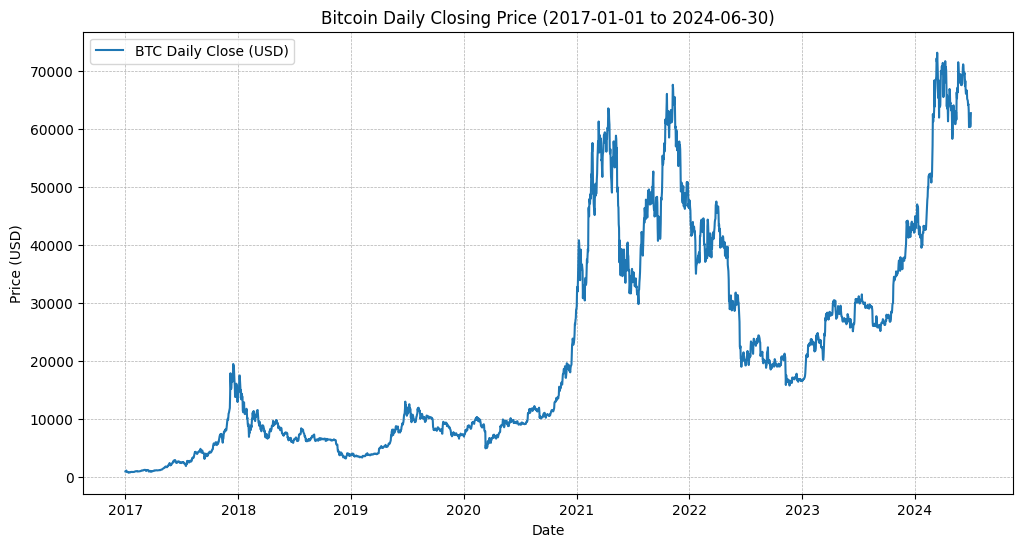

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(data.index, data["data"], label="BTC Daily Close (USD)")
plt.title("Bitcoin Daily Closing Price (2017-01-01 to 2024-06-30)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

# Step 2: Data Preprocessing
1. Splitting the BTC data into training and testing sets (80% train, 20% test).
2. Use the median of the training data to scale the data and save the median.
2. Assume a yearly season as in the paper and create an integer phase index of shape (L, ) used to encode calendar seasonality.
3. Create a sequence of scaled raw prices of shape (L, 1) where L=30 is the lookback window.

In [ ]:
# ============================
# FIXED Step 2: split + phase + constant scaling + sequences
# - Use constant scale: x_scaled = x / PRICE_SCALE (no shift)
# - Save PRICE_SCALE so you can invert predictions later
# ============================

import joblib
from pathlib import Path
import numpy as np
import pandas as pd

# ---- 1) Chronological split ----
N = len(all_data)
split_idx      = int(TRAIN_SPLIT_RATIO * N)
trainval_block = all_data.iloc[:split_idx]
test_block     = all_data.iloc[split_idx:]

inner_idx = int((1.0 - VAL_FRAC) * len(trainval_block))
all_train = trainval_block.iloc[:inner_idx]
all_val   = trainval_block.iloc[inner_idx:]
all_test  = test_block

print(f"all_train: {all_train.shape}, all_val: {all_val.shape}, all_test: {all_test.shape}")

# ---- 1.5) Continuous-season phase ----
M_SEASON = 365
EPOCH = pd.Timestamp("2017-01-01")

def compute_phase_continuous(idx: pd.DatetimeIndex, m: int = 365, epoch: pd.Timestamp = EPOCH) -> np.ndarray:
    days = (idx.normalize() - epoch).days.astype(int)
    return (days % m).astype("int32")

phase_train = compute_phase_continuous(all_train.index, m=M_SEASON)
phase_val   = compute_phase_continuous(all_val.index,   m=M_SEASON)
phase_test  = compute_phase_continuous(all_test.index,  m=M_SEASON)

# ---- 2) BTC constant scale ONLY (NO MinMax) ----
# Choose a stable positive constant from TRAIN only
PRICE_SCALE = float(all_train["BTC"].median())

def scale_const(df: pd.DataFrame, scale: float) -> pd.DataFrame:
    return pd.DataFrame(
        (df[["BTC"]].astype("float32") / np.float32(scale)).values,
        index=df.index,
        columns=["data_scaled"],
    )

btc_train_scaled = scale_const(all_train, PRICE_SCALE)
btc_val_scaled   = scale_const(all_val,   PRICE_SCALE)
btc_test_scaled  = scale_const(all_test,  PRICE_SCALE)

# SAVE THE SCALE CONSTANT
drive_dir = Path("/content/drive/MyDrive/helformer_runs/model2")
if drive_dir.exists():
    SCALE_OUT = drive_dir / "price_scale_const.joblib"
else:
    SCALE_OUT = Path("./price_scale_const.joblib")

SCALE_OUT.parent.mkdir(parents=True, exist_ok=True)
joblib.dump(PRICE_SCALE, str(SCALE_OUT))
print("Saved PRICE_SCALE to:", str(SCALE_OUT), "=", PRICE_SCALE)

# ---- 3) Build sequences WITH phase (BTC only) ----
def create_sequences_with_phase(scaled_df, phase_arr, seq_len, horizon=1):
    X, P, y, idx = [], [], [], []
    s = scaled_df["data_scaled"].values.astype("float32")
    for i in range(len(s) - seq_len - horizon + 1):
        X.append(s[i:i+seq_len].reshape(seq_len, 1))
        P.append(phase_arr[i:i+seq_len])
        y.append(s[i+seq_len+horizon-1])
        idx.append(scaled_df.index[i+seq_len+horizon-1])
    return (
        np.asarray(X, dtype="float32"),
        np.asarray(P, dtype="int32"),
        np.asarray(y, dtype="float32").reshape(-1, 1),  # (n,1) safer for Keras
        idx
    )

X_train, P_train, y_train, train_idx = create_sequences_with_phase(btc_train_scaled, phase_train, SEQUENCE_LENGTH, FORECAST_HORIZON)
X_val,   P_val,   y_val,   val_idx   = create_sequences_with_phase(btc_val_scaled,   phase_val,   SEQUENCE_LENGTH, FORECAST_HORIZON)
X_test,  P_test,  y_test,  test_idx  = create_sequences_with_phase(btc_test_scaled,  phase_test,  SEQUENCE_LENGTH, FORECAST_HORIZON)

print("X_train", X_train.shape, "P_train", P_train.shape, "y_train", y_train.shape)
print("X_val  ", X_val.shape,   "P_val  ", P_val.shape,   "y_val  ", y_val.shape)
print("X_test ", X_test.shape,  "P_test ", P_test.shape,  "y_test ", y_test.shape)

# NOTE: to invert any predicted scaled price back to USD later:
# price_hat_usd = price_hat_scaled * PRICE_SCALE


all_train: (1752, 1), all_val: (438, 1), all_test: (548, 1)


/tmp/ipython-input-1272798184.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  PRICE_SCALE = float(all_train["BTC"].median())


Saved PRICE_SCALE to: /content/drive/MyDrive/helformer_runs/model2/price_scale_const.joblib = 8321.38134765625
X_train (1722, 30, 1) P_train (1722, 30) y_train (1722, 1)
X_val   (408, 30, 1) P_val   (408, 30) y_val   (408, 1)
X_test  (518, 30, 1) P_test  (518, 30) y_test  (518, 1)


 # Step 3: Helformer Model Definition (TensorFlow2/Keras)
 This step defines the Helformer model architecture using Tensorflow.

 We define the Holt-Winters smoothing layer using the corrected formulas following *A hybrid method in exponential smoothing and recurrent neural networks for time series forecasting* by Slawek Smyl:
 \begin{align}
 L_t&=\alpha \frac{X_t}{S_{t}}+(1-\alpha)L_{t-1}, \\
 S_{t+m}&=\gamma\frac{X_t}{L_t}+(1-\gamma)S_t, \\
 Y_t&=\frac{X_t}{S_t L_t}.
 \end{align}
where $X_t$ is the closing price on day $t$, $m=365$ is the number of observed data in a season where we assume a yearly season as in Step 2.





In [2]:
# STEP 3: Model definition (FIXED: multiply scale back via HW 1-step baseline)
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, initializers

# ---- HW: global seasonal template indexed by absolute phase ----
@tf.keras.utils.register_keras_serializable(package="Helformer")
class HoltWintersSmoothing(layers.Layer):
    """
    Learns global seasonal template S_k (k=0..m-1).
    Local level recursion L_t within each window:
        L_t = α * (X_t / S_{k_t}) + (1-α) L_{t-1}

    Outputs:
      y_norm   : (B,T,1)  = X_t / (S_{k_t} * L_t)
      base_next: (B,1)    = 1-step HW baseline forecast for next day
                           base_{t+1} = L_t_last * S_{k_{t_last}+1}
    """
    def __init__(self, m=365, alpha_init=0.2, eps=1e-6, **kw):
        super().__init__(**kw)
        self.m = int(m)
        self.alpha_init = float(alpha_init)
        self.eps = float(eps)

    def build(self, _):
        self.season_raw = self.add_weight(
            name="season_raw", shape=(self.m, 1),
            initializer=initializers.Zeros(),
            trainable=True, dtype=self.dtype
        )

        def inv_sigmoid(p):
            p = tf.clip_by_value(tf.constant(p, dtype=self.dtype), 1e-6, 1 - 1e-6)
            return tf.math.log(p) - tf.math.log(1 - p)

        self.alpha_raw = self.add_weight(
            name="alpha_raw", shape=(),
            initializer=initializers.Constant(inv_sigmoid(self.alpha_init)),
            trainable=True, dtype=self.dtype
        )
        super().build(_)

    @property
    def alpha(self):
        return tf.nn.sigmoid(self.alpha_raw)

    def get_config(self):
        cfg = super().get_config()
        cfg.update(dict(m=self.m, alpha_init=self.alpha_init, eps=self.eps))
        return cfg

    def call(self, inputs):
        x, phase = inputs  # x: (B,T,1), phase: (B,T)
        eps = tf.cast(self.eps, x.dtype)

        # seasonal template > 1
        season = 1.0 + tf.nn.softplus(self.season_raw)   # (m,1)

        # gather S_{k_t} for each timestep
        S = tf.gather(season[:, 0], phase)               # (B,T)
        S = tf.maximum(tf.expand_dims(S, -1), eps)       # (B,T,1)

        # init level
        x0 = tf.maximum(x[:, 0, :], eps)                 # (B,1)
        S0 = tf.maximum(S[:, 0, :], eps)                 # (B,1)
        L0 = tf.maximum(x0 / (S0 + eps), eps)            # (B,1)

        xT = tf.transpose(x, [1, 0, 2])                  # (T,B,1)
        ST = tf.transpose(S, [1, 0, 2])                  # (T,B,1)

        def level_step(L_prev, xs):
            x_t, S_t = xs
            L_t = self.alpha * (x_t / (S_t + eps)) + (1.0 - self.alpha) * L_prev
            return tf.maximum(L_t, eps)

        LT = tf.scan(level_step, (xT, ST), initializer=L0)  # (T,B,1)
        L  = tf.transpose(LT, [1, 0, 2])                    # (B,T,1)

        # normalized stream
        y_norm = x / (S * L + eps)                           # (B,T,1)

        # 1-step baseline forecast base_{t+1} = L_last * S_{k_next}
        phase_last = phase[:, -1]                            # (B,)
        phase_next = tf.math.floormod(phase_last + 1, self.m)
        S_next = tf.gather(season[:, 0], phase_next)         # (B,)
        S_next = tf.maximum(S_next, eps)
        L_last = L[:, -1, 0]                                 # (B,)
        base_next = tf.expand_dims(L_last * S_next, -1)      # (B,1)

        return y_norm, base_next


@tf.keras.utils.register_keras_serializable(package="Helformer")
class PhaseSinCos(layers.Layer):
    def __init__(self, m=365, **kw):
        super().__init__(**kw)
        self.m = int(m)

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"m": self.m})
        return cfg

    def call(self, p_in):
        phase_f = tf.cast(p_in, tf.float32)
        ang = (2.0 * np.pi / float(self.m)) * phase_f
        sinp = tf.sin(ang)[..., None]
        cosp = tf.cos(ang)[..., None]
        return layers.Concatenate(axis=-1)([sinp, cosp])


@tf.keras.utils.register_keras_serializable(package="Helformer")
class HelformerBlock(layers.Layer):
    def __init__(self, d_model=64, heads=4, dropout=0.1, lstm_units=32, **kw):
        super().__init__(**kw)
        self.d_model = int(d_model)
        self.heads = int(heads)
        self.dropout = float(dropout)
        self.lstm_units = int(lstm_units)

        if self.d_model % self.heads != 0:
            raise ValueError(f"d_model ({self.d_model}) must be divisible by heads ({self.heads}).")

        self.mha  = layers.MultiHeadAttention(
            num_heads=self.heads,
            key_dim=self.d_model // self.heads,
            dropout=self.dropout
        )
        self.do1  = layers.Dropout(self.dropout)
        self.ln1  = layers.LayerNormalization(epsilon=1e-5)
        self.lstm = layers.LSTM(self.lstm_units, return_sequences=True)
        self.proj = layers.Dense(self.d_model)
        self.do2  = layers.Dropout(self.dropout)
        self.ln2  = layers.LayerNormalization(epsilon=1e-5)

    def get_config(self):
        cfg = super().get_config()
        cfg.update({
            "d_model": self.d_model,
            "heads": self.heads,
            "dropout": self.dropout,
            "lstm_units": self.lstm_units,
        })
        return cfg

    def call(self, x, training=False):
        attn = self.mha(x, x, use_causal_mask=True, training=training)
        x = self.ln1(x + self.do1(attn, training=training))
        y = self.proj(self.lstm(x, training=training))
        return self.ln2(x + self.do2(y, training=training))


def build_helformer(
    seq_len=30, d_model=64, heads=4, blocks=1, lstm_units=32,
    dropout=0.1, m=365, out_dim=1
):
    x_in = layers.Input(shape=(seq_len, 1), dtype=tf.float32, name="x")
    p_in = layers.Input(shape=(seq_len,), dtype=tf.int32, name="phase")

    # HW normalize + baseline for next day
    y_norm, base_next = HoltWintersSmoothing(m=m)([x_in, p_in])  # (B,T,1), (B,1)

    ph = PhaseSinCos(m=m)(p_in)                                  # (B,T,2)
    y  = layers.Concatenate(axis=-1)([y_norm, ph])               # (B,T,3)

    h = layers.Dense(d_model)(y)
    for _ in range(blocks):
        h = HelformerBlock(d_model, heads, dropout, lstm_units)(h)

    h = layers.LSTM(lstm_units, return_sequences=False)(h)

    # predict multiplicative residual multiplier (positive), then multiply back baseline
    # multiplier = exp(raw) keeps it > 0 and naturally centered near 1 when raw ~ 0
    raw = layers.Dense(out_dim)(h)                               # (B,1)
    mult = layers.Lambda(tf.exp, name="mult_exp")(raw)           # (B,1)
    out_price = layers.Multiply(name="price_hat")([mult, base_next])  # (B,1)

    return models.Model([x_in, p_in], out_price, name="Helformer")


# Step 4: Hyperparameters optimization (Optuna)

In [ ]:
# STEP 4: Optuna tuning (fresh-start capable)

!pip -q install optuna optuna-integration[tfkeras]

import os, random, gc, json, shutil
from pathlib import Path
import numpy as np
import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner
from optuna.trial import TrialState

import tensorflow as tf
from tensorflow.keras import optimizers

# -----------------------
# Seed (CONSISTENT)
# -----------------------
SEED = 123
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# (Optional determinism; harmless if not supported)
try:
    tf.config.experimental.enable_op_determinism()
except Exception:
    pass

# IMPORTANT: Optuna stability > speed. Mixed precision/jit often causes NaNs / nonrepro per-trial.
# Keep float32 for tuning.
try:
    tf.keras.mixed_precision.set_global_policy("float32")
except Exception:
    pass

MAX_EPOCHS = 100
TOTAL_TRIALS = 50

# -----------------------
# Model2 paths (Drive)
# -----------------------
DRIVE_DIR = Path("/content/drive/MyDrive/helformer_runs/model2")
DRIVE_DIR.mkdir(parents=True, exist_ok=True)

PARAMS_PATH = DRIVE_DIR / "best_params_model2.json"
DB_PATH     = DRIVE_DIR / "optuna_helformer_model2.sqlite3"
storage_url = f"sqlite:///{DB_PATH}"

# -----------------------
# Temp path (tie to model2)
# -----------------------
TMP_BASE = Path("/tmp/helformer_optuna_model2")
TMP_BASE.mkdir(parents=True, exist_ok=True)

# -----------------------
# FRESH START switch
# -----------------------
FRESH_START = True  # <<<<<< set True to rebuild model2 from scratch
STUDY_NAME  = "helformer_price_model2"  # keep stable for model2

if FRESH_START:
    if DB_PATH.exists():
        DB_PATH.unlink()
    if PARAMS_PATH.exists():
        PARAMS_PATH.unlink()
    if TMP_BASE.exists():
        shutil.rmtree(TMP_BASE)
    TMP_BASE.mkdir(parents=True, exist_ok=True)

print("Optuna storage_url:", storage_url)
print("FRESH_START:", FRESH_START)
print("TMP_BASE:", str(TMP_BASE))

def make_checkpoint(run_tag: str):
    run_dir = TMP_BASE / run_tag
    if run_dir.exists():
        shutil.rmtree(run_dir)
    run_dir.mkdir(parents=True, exist_ok=True)

    best_weights_path = str(run_dir / "best.weights.h5")

    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=best_weights_path,
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        save_weights_only=True,
        verbose=0,
    )
    return checkpoint_cb

def objective(trial):
    tf.keras.backend.clear_session()
    gc.collect()

    # Per-trial seed (still deterministic given op determinism)
    trial_seed = SEED + trial.number
    random.seed(trial_seed)
    np.random.seed(trial_seed)
    tf.random.set_seed(trial_seed)

    # ---- search space ----
    blocks     = trial.suggest_int("blocks", 1, 4)
    heads      = trial.suggest_int("heads", 2, 10, step=2)
    head_size  = trial.suggest_int("head_size", 8, 64, step=8)
    d_model    = heads * head_size                   # divisible by heads by construction
    lstm_units = trial.suggest_int("lstm_units", 16, 64, step=8)
    dropout    = trial.suggest_float("dropout", 0.0, 0.3)
    lr         = trial.suggest_float("lr", 1e-4, 3e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256, 512])
    huber_delta = trial.suggest_float("huber_delta", 0.005, 0.05, log=True)

    seq_len = int(X_train.shape[1])
    out_dim = 1  # raw-price forecast (scaled units), always scalar

    model = build_helformer(
        seq_len=seq_len,
        d_model=d_model,
        heads=heads,
        blocks=blocks,
        lstm_units=lstm_units,
        dropout=dropout,
        m=M_SEASON,
        out_dim=out_dim,
    )

    # Robust loss (raw price has outliers; also avoids MSE blowing up per trial)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr, clipnorm=1.0),
        loss=tf.keras.losses.Huber(delta=huber_delta),
        metrics=[tf.keras.metrics.MAE],
        jit_compile=False,  # << important for Optuna speed/stability
    )

    run_tag = f"trial_{trial.number}"
    checkpoint_cb = make_checkpoint(run_tag)

    pruning_cb = TFKerasPruningCallback(trial, monitor="val_loss")
    earlystop_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=8,
        restore_best_weights=True,
    )
    nan_cb = tf.keras.callbacks.TerminateOnNaN()

    history = model.fit(
        [X_train, P_train], y_train,
        validation_data=([X_val, P_val], y_val),
        epochs=MAX_EPOCHS,
        batch_size=batch_size,
        shuffle=False,
        callbacks=[checkpoint_cb, pruning_cb, earlystop_cb, nan_cb],
        verbose=0,
    )

    # Get best val_loss; guard NaNs
    val_losses = history.history.get("val_loss", [])
    if len(val_losses) == 0:
        return float("inf")

    best = float(np.nanmin(val_losses))
    if not np.isfinite(best):
        best = float("inf")

    # cleanup
    del model
    gc.collect()
    return best

study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=storage_url,
    load_if_exists=not FRESH_START,
    direction="minimize",
    sampler=TPESampler(seed=SEED, multivariate=True, group=True),
    pruner=HyperbandPruner(min_resource=10, max_resource=MAX_EPOCHS, reduction_factor=3),
)

done = len(study.get_trials(
    deepcopy=False,
    states=(TrialState.COMPLETE, TrialState.PRUNED, TrialState.FAIL)
))
remaining = max(0, TOTAL_TRIALS - done)
print(f"Study '{STUDY_NAME}': done={done}, remaining={remaining}, target_total={TOTAL_TRIALS}")
print("Optuna DB:", str(DB_PATH))

if remaining > 0:
    study.optimize(objective, n_trials=remaining, n_jobs=1, gc_after_trial=True)

print("Best val loss:", study.best_value)
print("Best params:", study.best_params)

with open(PARAMS_PATH, "w") as f:
    json.dump(study.best_trial.params, f, indent=2)
print("Saved best params to:", str(PARAMS_PATH))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.4 MB/s eta 0:00:00
Optuna storage_url: sqlite:////content/drive/MyDrive/helformer_runs/model2/optuna_helformer_model2.sqlite3
FRESH_START: True
TMP_BASE: /tmp/helformer_optuna_model2


/usr/local/lib/python3.12/dist-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-12-31 09:16:25,488] A new study created in RDB with name: helformer_price_model2


Study 'helformer_price_model2': done=0, remaining=50, target_total=50
Optuna DB: /content/drive/MyDrive/helformer_runs/model2/optuna_helformer_model2.sqlite3


[I 2025-12-31 09:17:17,663] Trial 0 finished with value: 0.0016080518253147602 and parameters: {'blocks': 3, 'heads': 4, 'head_size': 16, 'lstm_units': 40, 'dropout': 0.2158406909356689, 'lr': 0.00042167664250477427, 'batch_size': 64, 'huber_delta': 0.011019148109145376}. Best is trial 0 with value: 0.0016080518253147602.
[I 2025-12-31 09:17:38,349] Trial 1 pruned. Trial was pruned at epoch 10.
[I 2025-12-31 09:18:12,316] Trial 2 finished with value: 0.0023303136695176363 and parameters: {'blocks': 3, 'heads': 8, 'head_size': 48, 'lstm_units': 32, 'dropout': 0.10853659668669423, 'lr': 0.00021735641882032405, 'batch_size': 128, 'huber_delta': 0.013484435419296696}. Best is trial 0 with value: 0.0016080518253147602.
[I 2025-12-31 09:18:35,880] Trial 3 finished with value: 0.0019398049917072058 and parameters: {'blocks': 2, 'heads': 6, 'head_size': 24, 'lstm_units': 32, 'dropout': 0.26801674893514044, 'lr': 0.002481068933263618, 'batch_size': 128, 'huber_delta': 0.012995596434393571}. Bes

Best val loss: 0.0007895404123701155
Best params: {'blocks': 2, 'heads': 2, 'head_size': 48, 'lstm_units': 40, 'dropout': 0.1893640156272847, 'lr': 0.0008351132839411927, 'batch_size': 512, 'huber_delta': 0.005439550675476963}
Saved best params to: /content/drive/MyDrive/helformer_runs/model2/best_params_model2.json


# Step 5: Model training with the best hyperparameters

In [ ]:
# STEP 5: Refit and save FINAL model to Drive (model2, robust + overwrite-safe)
# NOTE: Step 2 saves:  /content/drive/MyDrive/helformer_runs/model2/price_scale_const.joblib
# Here we ONLY verify it exists (no re-saving).

import os, json, random, shutil, gc
from pathlib import Path
import numpy as np
import tensorflow as tf

# -----------------------
# Seed (match Step 4)
# -----------------------
SEED = 123
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

try:
    tf.config.experimental.enable_op_determinism()
except Exception:
    pass

# IMPORTANT: keep float32 for refit stability (match corrected Step 4)
try:
    tf.keras.mixed_precision.set_global_policy("float32")
except Exception:
    pass

# -----------------------
# Paths
# -----------------------
TMP_BASE = Path("/tmp/helformer_optuna_model2")
TMP_BASE.mkdir(parents=True, exist_ok=True)

RUN_TAG = "refit_final_model2"
RUN_DIR = TMP_BASE / RUN_TAG

# IMPORTANT: remove any old checkpoint state
if RUN_DIR.exists():
    shutil.rmtree(RUN_DIR)
RUN_DIR.mkdir(parents=True, exist_ok=True)

# Local checkpoint path (fast)
REFIT_BEST_WEIGHTS = str(RUN_DIR / "best.weights.h5")

# Drive paths (model2 folder)
DRIVE_DIR = Path("/content/drive/MyDrive/helformer_runs/model2")
DRIVE_DIR.mkdir(parents=True, exist_ok=True)

PARAMS_PATH      = DRIVE_DIR / "best_params_model2.json"
FINAL_MODEL_PATH = DRIVE_DIR / "final_refit_model2.keras"

# ---- verify constant scale (saved in Step 2) ----
SCALE_PATH = DRIVE_DIR / "price_scale_const.joblib"
if not SCALE_PATH.exists():
    raise FileNotFoundError(
        f"Missing scale file: {SCALE_PATH}\n"
        "Run STEP 2 (constant scaling on TRAIN) and save price_scale_const.joblib before running STEP 5."
    )
print("Found PRICE_SCALE (from Step 2):", str(SCALE_PATH))

# Optional overwrite behavior (only if you have FRESH_START defined)
if "FRESH_START" in globals() and FRESH_START and FINAL_MODEL_PATH.exists():
    FINAL_MODEL_PATH.unlink()

# -----------------------
# Load best hyperparameters from Drive
# -----------------------
with open(PARAMS_PATH, "r") as f:
    best_params = json.load(f)
print("Loaded hyperparameters:", best_params)

blocks      = int(best_params["blocks"])
heads       = int(best_params["heads"])
head_size   = int(best_params["head_size"])
d_model     = heads * head_size
lstm_units  = int(best_params["lstm_units"])
dropout     = float(best_params["dropout"])
lr          = float(best_params["lr"])
batch_size  = int(best_params["batch_size"])
huber_delta = float(best_params.get("huber_delta", 0.01))  # if older params file, fall back

MAX_EPOCHS = 100  # must match Step 4
seq_len = int(X_train.shape[1])
out_dim = 1  # price scalar (scaled units)

# -----------------------
# Build & compile
# -----------------------
tf.keras.backend.clear_session()
gc.collect()

model = build_helformer(
    seq_len=seq_len,
    d_model=d_model,
    heads=heads,
    blocks=blocks,
    lstm_units=lstm_units,
    dropout=dropout,
    m=M_SEASON,
    out_dim=out_dim,
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0),
    loss=tf.keras.losses.Huber(delta=huber_delta),
    metrics=[tf.keras.metrics.MAE],
    jit_compile=False,   # keep stable for saving/loading
)

# -----------------------
# Callbacks: best weights only
# -----------------------
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=REFIT_BEST_WEIGHTS,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=8,
    restore_best_weights=False,  # we'll reload best weights explicitly
)

nan_cb = tf.keras.callbacks.TerminateOnNaN()

history = model.fit(
    [X_train, P_train], y_train,
    validation_data=([X_val, P_val], y_val),
    epochs=MAX_EPOCHS,
    batch_size=batch_size,
    shuffle=False,
    callbacks=[checkpoint_cb, earlystop_cb, nan_cb],
    verbose=1,
)

# -----------------------
# Reload best weights, then save model to Drive
# -----------------------
model.load_weights(REFIT_BEST_WEIGHTS)

# Optional sanity check predict once
_ = model.predict([X_val[:2], P_val[:2]], verbose=0)

# Save to Drive (overwrite-safe)
if FINAL_MODEL_PATH.exists():
    FINAL_MODEL_PATH.unlink()
model.save(FINAL_MODEL_PATH)
print("Saved final refit model to:", str(FINAL_MODEL_PATH))


Found PRICE_SCALE (from Step 2): /content/drive/MyDrive/helformer_runs/model2/price_scale_const.joblib
Loaded hyperparameters: {'blocks': 2, 'heads': 2, 'head_size': 48, 'lstm_units': 40, 'dropout': 0.1893640156272847, 'lr': 0.0008351132839411927, 'batch_size': 512, 'huber_delta': 0.005439550675476963}
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0029 - mean_absolute_error: 0.5277
Epoch 1: val_loss improved from inf to 0.00378, saving model to /tmp/helformer_optuna_model2/refit_final_model2/best.weights.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 406ms/step - loss: 0.0032 - mean_absolute_error: 0.5985 - val_loss: 0.0038 - val_mean_absolute_error: 0.6968
Epoch 2/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0012 - mean_absolute_error: 0.2164    
Epoch 2: val_loss did not improve from 0.00378
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0018 - mean_absolute_error: 0.3335 - val_loss: 0.0067 - val_mean_absolute_error: 1.2268
Epoch 3/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - l

# Before running the following cell, upload final_refit_model2.keras and price_scale_const.joblib on Github to the current directory of this notebook

In [3]:
# ======================================================
# LOAD MODEL2 (RAW-PRICE)
# Required in CURRENT DIRECTORY:
#   - final_refit_model2.keras
#   - price_scale_const.joblib
# ======================================================

import json, zipfile, shutil
from pathlib import Path
import joblib
import numpy as np

MODEL_PATH = Path("./final_refit_model2.keras")
SCALE_PATH = Path("./price_scale_const.joblib")

# ---- load constant scale ----
if not SCALE_PATH.exists():
    raise FileNotFoundError(f"Missing {SCALE_PATH.resolve()}")
PRICE_SCALE = float(joblib.load(str(SCALE_PATH)))
print("Loaded PRICE_SCALE =", PRICE_SCALE)

if not MODEL_PATH.exists():
    raise FileNotFoundError(f"Missing {MODEL_PATH.resolve()}")

# ------------------------------------------------------
# Helper: infer architecture from config.json inside .keras
# ------------------------------------------------------
def _get_model_cfg(cfg: dict) -> dict:
    # common nestings across keras versions
    if cfg.get("class_name") == "Functional" and "config" in cfg:
        return cfg
    if "model_config" in cfg and isinstance(cfg["model_config"], dict):
        return cfg["model_config"]
    # sometimes: {"class_name":"Model","config":{"model_config":{...}}}
    if "config" in cfg and isinstance(cfg["config"], dict) and "model_config" in cfg["config"]:
        return cfg["config"]["model_config"]
    return cfg

def infer_arch_from_keras(keras_path: Path) -> dict:
    with zipfile.ZipFile(keras_path, "r") as z:
        names = z.namelist()
        if "config.json" not in names:
            raise RuntimeError("No config.json found inside .keras (unexpected).")
        cfg = json.loads(z.read("config.json").decode("utf-8"))

    cfg = _get_model_cfg(cfg)
    if cfg.get("class_name") != "Functional":
        raise RuntimeError(f"Expected Functional model config, got: {cfg.get('class_name')}")

    layers_cfg = cfg["config"]["layers"]
    out_layers = cfg["config"]["output_layers"]
    out_layer_name = out_layers[0][0]

    seq_len = None
    m_season = None
    blocks = 0
    d_model = None
    heads = None
    lstm_units = None
    dropout = None
    out_dim = None

    # infer seq_len from input layer named "x" if present; otherwise first InputLayer
    for layer in layers_cfg:
        cname = layer.get("class_name")
        lcfg = layer.get("config", {})
        lname = lcfg.get("name", "")

        if cname == "InputLayer" and (lname == "x" or seq_len is None):
            bs = lcfg.get("batch_shape") or lcfg.get("batch_input_shape")
            if bs and len(bs) >= 3 and bs[1] is not None:
                seq_len = int(bs[1])

        if cname == "HoltWintersSmoothing" and m_season is None:
            m_season = int(lcfg.get("m", 365))

        if cname == "HelformerBlock":
            blocks += 1
            # first block carries hyperparams in its config (because you implemented get_config)
            if d_model is None:
                d_model = int(lcfg["d_model"])
                heads = int(lcfg["heads"])
                lstm_units = int(lcfg["lstm_units"])
                dropout = float(lcfg["dropout"])

        if cname == "Dense" and lname == out_layer_name:
            out_dim = int(lcfg.get("units", 1))

    # fallbacks
    if seq_len is None:
        seq_len = 30
    if m_season is None:
        m_season = 365
    if out_dim is None:
        out_dim = 1

    if any(v is None for v in [d_model, heads, lstm_units, dropout]) or blocks == 0:
        raise RuntimeError(
            "Could not infer model hyperparams from config.json.\n"
            "This usually means the saved model does NOT contain HelformerBlock configs\n"
            "(e.g., you saved a different architecture than your current Step 3 code)."
        )

    return dict(
        seq_len=seq_len,
        m=m_season,
        blocks=blocks,
        d_model=d_model,
        heads=heads,
        lstm_units=lstm_units,
        dropout=dropout,
        out_dim=out_dim,
    )

# ------------------------------------------------------
# Helper: extract weights file from .keras zip
# ------------------------------------------------------
def extract_weights_from_keras(keras_path: Path, extract_dir: Path) -> Path:
    if extract_dir.exists():
        shutil.rmtree(extract_dir)
    extract_dir.mkdir(parents=True, exist_ok=True)

    with zipfile.ZipFile(keras_path, "r") as z:
        names = z.namelist()
        # common name
        if "model.weights.h5" in names:
            wname = "model.weights.h5"
        else:
            cand = [n for n in names if n.endswith(".h5") and "weights" in n]
            if not cand:
                raise RuntimeError("No weights .h5 found inside .keras.")
            wname = sorted(cand, key=len)[0]
        z.extract(wname, path=extract_dir)

    return extract_dir / wname

# ------------------------------------------------------
# 1) Rebuild from saved config + load weights (no graph deserialization)
# ------------------------------------------------------
arch = infer_arch_from_keras(MODEL_PATH)
print("Inferred architecture from saved model:", arch)

weights_path = extract_weights_from_keras(MODEL_PATH, Path("./_extract_model2"))
print("Extracted weights:", weights_path)

model2 = build_helformer(
    seq_len=int(arch["seq_len"]),
    d_model=int(arch["d_model"]),
    heads=int(arch["heads"]),
    blocks=int(arch["blocks"]),
    lstm_units=int(arch["lstm_units"]),
    dropout=float(arch["dropout"]),
    m=int(arch["m"]),
    out_dim=int(arch["out_dim"]),
)

# IMPORTANT: load weights AFTER building the exact architecture
model2.load_weights(str(weights_path))
print("SUCCESS: model2 rebuilt + weights loaded.")

# ------------------------------------------------------
# Usage reminder:
# model2 outputs SCALED next-day price; multiply by PRICE_SCALE for USD
# ------------------------------------------------------
print("Model output: Pscaled_hat_{t+1}. Convert: Phat_usd = pred_scaled * PRICE_SCALE")




Loaded PRICE_SCALE = 8321.38134765625
Inferred architecture from saved model: {'seq_len': 30, 'm': 365, 'blocks': 2, 'd_model': 96, 'heads': 2, 'lstm_units': 40, 'dropout': 0.1893640156272847, 'out_dim': 1}
Extracted weights: _extract_model2/model.weights.h5
SUCCESS: model2 rebuilt + weights loaded.
Model output: Pscaled_hat_{t+1}. Convert: Phat_usd = pred_scaled * PRICE_SCALE


In [9]:
import numpy as np
import pandas as pd
import yfinance as yf
import joblib
from pathlib import Path
from sklearn.metrics import r2_score, mean_absolute_error

# ---------------- Config ----------------
SEQ_LEN  = 30
M_SEASON = 365
EPOCH    = pd.Timestamp("2017-01-01")

START = "2017-01-01"
END   = "2024-06-30"
DOWNLOAD_END = (pd.Timestamp(END) + pd.Timedelta(days=2)).strftime("%Y-%m-%d")

SCALE_PATH = Path("./price_scale_const.joblib")   # could be scaler OR float constant

if not SCALE_PATH.exists():
    raise FileNotFoundError(f"Missing: {SCALE_PATH}")

scale_obj = joblib.load(SCALE_PATH)
print("Loaded scale object type:", type(scale_obj))
print("Loaded scale object repr:", scale_obj)

def has_scaler_api(obj):
    return hasattr(obj, "transform") and hasattr(obj, "inverse_transform")

def scale_forward(x_colvec: np.ndarray) -> np.ndarray:
    """x_colvec shape (n,1) -> scaled colvec (n,1)"""
    if has_scaler_api(scale_obj):
        return scale_obj.transform(x_colvec).astype(np.float32)
    # constant scaling: x_scaled = x / c
    c = float(scale_obj)
    if not np.isfinite(c) or c == 0.0:
        raise ValueError(f"Bad constant scale value: {c}")
    return (x_colvec / c).astype(np.float32)

def scale_inverse(x_scaled_colvec: np.ndarray) -> np.ndarray:
    """scaled colvec (n,1) -> raw colvec (n,1)"""
    if has_scaler_api(scale_obj):
        return scale_obj.inverse_transform(x_scaled_colvec).astype(np.float64)
    # constant scaling inverse: x = x_scaled * c
    c = float(scale_obj)
    return (x_scaled_colvec.astype(np.float64) * c)

# ---------------- 1) Download BTC close ----------------
raw = yf.download(
    "BTC-USD",
    start=START,
    end=DOWNLOAD_END,
    interval="1d",
    auto_adjust=True,
    progress=False
)
if raw.empty:
    raise RuntimeError("No data downloaded from yfinance.")

if isinstance(raw.columns, pd.MultiIndex):
    try:
        close = raw.xs("Close", level=1, axis=1)
        close.columns = ["BTC"]
    except Exception:
        close = raw[["Close"]].copy()
        close.columns = ["BTC"]
else:
    close = raw[["Close"]].rename(columns={"Close":"BTC"})

# calendar align daily + ffill
full_idx = pd.date_range(close.index.min(), close.index.max(), freq="D")
close = close.reindex(full_idx).ffill()
close.index.name = "Date"

# restrict to exact span
close = close.loc[pd.Timestamp(START):pd.Timestamp(END)]
print("Close span:", close.index.min().date(), "to", close.index.max().date(), "N=", len(close))

# ---------------- 2) Phase ----------------
def compute_phase_continuous(idx: pd.DatetimeIndex, m: int = 365, epoch: pd.Timestamp = EPOCH) -> np.ndarray:
    days = (idx.normalize() - epoch).days.astype(int)
    return (days % m).astype("int32")

phase_all = compute_phase_continuous(close.index, m=M_SEASON)

# ---------------- 3) Last-20% TEST block ----------------
N = len(close)
split_idx = int(0.8 * N)

test_close = close.iloc[split_idx:].copy()
test_phase = phase_all[split_idx:].copy()

print("split_idx:", split_idx)
print("Test span:", test_close.index.min().date(), "to", test_close.index.max().date(), "N_test=", len(test_close))

# ---------------- 4) Scale close (using TRAIN-fitted artifact or constant) ----------------
test_scaled_col = scale_forward(test_close[["BTC"]].values.astype(np.float64))  # (n,1)
test_scaled = test_scaled_col.reshape(-1).astype(np.float32)

# ---------------- 5) Windowing within TEST (predict next day) ----------------
X_test, P_test = [], []
y_true_price = []
idx_true = []

for i in range(SEQ_LEN - 1, len(test_scaled) - 1):
    X_test.append(test_scaled[i-SEQ_LEN+1:i+1].reshape(SEQ_LEN, 1))
    P_test.append(test_phase[i-SEQ_LEN+1:i+1])
    y_true_price.append(float(test_close["BTC"].iloc[i+1]))
    idx_true.append(test_close.index[i+1])

X_test = np.asarray(X_test, dtype=np.float32)
P_test = np.asarray(P_test, dtype=np.int32)
y_true_price = np.asarray(y_true_price, dtype=np.float64)

print("X_test:", X_test.shape, "P_test:", P_test.shape, "y_true:", y_true_price.shape)

# ---------------- 6) Predict scaled next-day close and invert ----------------
pred_scaled = model2.predict([X_test, P_test], batch_size=512, verbose=0)
pred_scaled = np.asarray(pred_scaled).reshape(-1, 1)

y_pred_price = scale_inverse(pred_scaled).reshape(-1)

# ---------------- 7) Metrics on PRICE ----------------
r2_price  = float(r2_score(y_true_price, y_pred_price))
mae_price = float(mean_absolute_error(y_true_price, y_pred_price))

print("\n===== Model2 on LAST-20% (PRICE) =====")
print(f"Targets span: {idx_true[0].date()} to {idx_true[-1].date()}")
print("Samples:", len(y_true_price))
print("R^2 :", r2_price)
print("MAE :", mae_price, "USD")

Loaded scale object type: <class 'float'>
Loaded scale object repr: 8321.38134765625
Close span: 2017-01-01 to 2024-06-30 N= 2738
split_idx: 2190
Test span: 2022-12-31 to 2024-06-30 N_test= 548
X_test: (518, 30, 1) P_test: (518, 30) y_true: (518,)

===== Model2 on LAST-20% (PRICE) =====
Targets span: 2023-01-30 to 2024-06-30
Samples: 518
R^2 : 0.9835906163259011
MAE : 1494.2737478339247 USD
